# Using LLMs as High-Level Planners for Multi-Agent Coordination

This notebook provides a step-by-step guide to customizing and interacting with the RL environment.

## For Submission
1. Fill in your code in `submit.py`. 
   - Add your code *only* in the TODO sections marked by the '#' delimiter lines. Do not modify any other parts of the script.
   - You should implement any helper functions/classes in a separate `helper.py` file and import them in `submit.py`.
1. Submit `out.log` and `results.csv` generated by the `submit.py` script.


In [1]:
# Import necessary libraries and modules
import gymnasium as gym
import multigrid.envs
import matplotlib.pyplot as plt
from agents import AgentCollection
from IPython.display import clear_output

%matplotlib inline
%load_ext autoreload
%autoreload 2

---
## Initial Plan Generation

An intial plan can be generated by the `initial_planner` by invoking it with the grid size and number of agents available.

In [2]:
import configparser

config = configparser.ConfigParser()
config.read("env_config.ini")

environments = {}
for section in config.sections():
    M = config.getint(section, "number_of_agents")
    N = config.getint(section, "grid_size")
    goals = eval(config.get(section, "goals"))
    mission_statement = eval(config.get(section, "mission_statement"))
    # num_trials = config.getint(section, "number_of_trials")
    environments[section] = {
        "N": N,
        "M": M,
        "goals": goals,
        "mission_statement": mission_statement,
    }

In [3]:
from models import local_llm as llm
from planner import PromptPlanner

In [9]:
selected_env = environments["env.AGENT_2_1"]
env = multigrid.envs.EmptyEnvV2(
    size=selected_env["N"],  # Specify the size of the grid, N
    agents=selected_env["M"],  # Specify number of agents, M
    goals=selected_env["goals"],  # Specify target positions for agents
    mission_space=selected_env["mission_statement"],
    render_mode="rgb_array",
    hidden_goals=True,
    # max_steps=50, # For debugging, you can set a maximum number of steps
)

# Always reset the environment before starting
observations, infos = env.reset()

agents = AgentCollection(num=selected_env["M"])

planner = PromptPlanner(
    llm=llm, grid_size=selected_env["N"], observations=observations, infos=infos
)

# Providing the agents with high-level instructions
mission = observations[0]["mission"]
plan = planner.initial_plan()
print(plan)
for agent, actions in plan.items():
    for action in actions:
        agents.tell({agent: action.serialize()})

**Natural Language Plan Outline: Locating 5 Targets in a 50×50 Grid with 3 Agents**

---

### **1. Mission Analysis & Target Likelihoods**
- **Grid size**: N = 50 → Valid interior exploration area is **[1, 48] × [1, 48]** (since outer walls at x=0, x=49, y=0, y=49 are impassable).
- **Total targets**: T = 5
- **Mission hints**:
  - **Four targets** are confined to the **[10,20] × [10,20]** square (11×11 = 121 cells).
  - **One target** is confined to the **[40,45] × [40,45]** square (6×6 = 36 cells).
- **Implication**: 
  - All 5 targets are **strictly localized** — no targets exist outside these two regions.
  - Therefore, **full-grid coverage is unnecessary**. Exploration can be highly focused.
  - The [10,20]×[10,20] region is dense (4/5 of targets), so it deserves priority and possibly multiple agents.
  - The [40,45]×[40,45] region is smaller but must still be fully covered.

---

### **2. Region Partitioning & Agent Assignment**
We have **M = 3 agents**, all starting at **(1,1)**

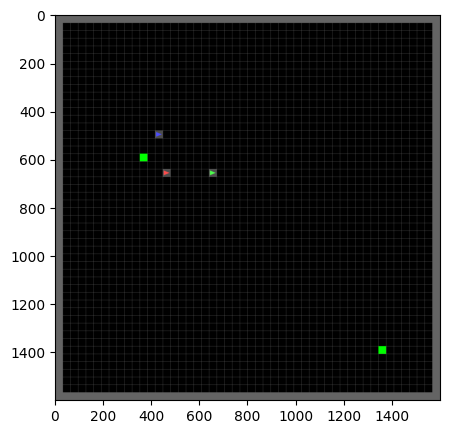


{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("Four targets are contained within the region from (10, 10) to (20, 20), one target is contained within the region from (40, 40) to (45, 45)."), 'location': (np.int64(14), np.int64(20))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("Four targets are contained within the region from (10, 10) to (20, 20), one target is contained within the region from (40, 40) to (45, 45)."), 'location': (np.int64(20), np.int64(20))}, 2: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("Four targets are contained within the region from (10, 10) to (20, 20), one target is contained within the region from (40, 40) to (45, 45)."), 'location': (np.int64(13), np.int64(15))}, 'global': {'num_goals': 2}}
{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.right: 1>, 2: <ActionUpDown.down: 3>} {0: -1, 1: -1, 2: 1} {0: np.False_, 1: np.False_, 2: np.False_} {0: False, 1: False

KeyboardInterrupt: 

In [10]:
text_plan = ""
while not env.unwrapped.is_done():
    # Obtain the low-level action for current time step for all agents
    a = agents.act()

    # Step the environment with the actions
    observations, rewards, terminations, truncations, infos = env.step(a)

    # Render the environment
    clear_output(wait=True)
    img = env.render()
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.show()
    print(text_plan)
    print(observations)
    print(a, rewards, terminations, truncations, infos)
    print(infos["total_reward"])

    plan, text_plan = planner.replan(
        agents, observations, rewards, terminations, truncations, infos
    )
    for agent, actions in plan.items():
        for action in actions:
            agents.tell({agent: action.serialize()})

print(infos["total_reward"])
env.close()